In [ ]:
# install and upgrade required library

!pip install --upgrade gensim
!pip install arabic_reshaper
!pip install python-bidi

**Preprocess**

Downlaod data and clean data 

In [ ]:
# download dataset
!gdown --id 1rovazK48q7pHcEM271aX70Dr594NYQ77
!gdown --id 1ZCHuj6JtyOkb5ismn3qF3Rp2DRGJ1tRk

Downloading...
From: https://drive.google.com/uc?id=1rovazK48q7pHcEM271aX70Dr594NYQ77
To: /content/train.csv
20.1MB [00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZCHuj6JtyOkb5ismn3qF3Rp2DRGJ1tRk
To: /content/test.csv
100% 2.03M/2.03M [00:00<00:00, 62.4MB/s]


In [ ]:
import pandas as pd

# read dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
# this function removes the punctuation marks and non-alphabetic words from given document 
# and returns an array of document words
def clean_text(doc):

  tokens = doc.split()
  translation_table = str.maketrans('', '', "><.،؟؛:{}\|+ـ()*&^٪$#❊!/[]=-")
  tokens = [word.translate(translation_table) for word in tokens]
  tokens = [word for word in tokens if word.isalpha()]

  return tokens

# **Q1**

In [ ]:
# prepare input for gensim word2vec model

train_words = []
for index, row in train.iterrows():
  train_words.append([row.id, clean_text(row.article)])

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# sg: Training algorithm: 1 for skip-gram; otherwise CBOW.
# min_count: Ignores all words with total frequency lower than this.
# window: Maximum distance between the current and predicted word within a sentence.
# size: Dimensionality of the word vectors.

# train word2ec model
w2v_model = Word2Vec(np.array(train_words)[:, 1], min_count=5, vector_size=300, window=10, sg=1)

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
from gensim.models.doc2vec import TaggedDocument

# prepare input for gensim doc2vec model
train_docs = [TaggedDocument(doc.article.split(" "), [doc.id]) for index, doc in train.iterrows()]

In [ ]:
from gensim.models import Doc2Vec

# train doc2vec model
d2v_model = Doc2Vec(train_docs, min_count=5, vector_size=300, window=10)

# **Q2**

In [ ]:
# this function creates two term_doc, and doc_term dictionaries
def create_tf_idf_dicts(docs, DIDs):
  
  # [key = T (term)] --> dict[key = D (doc)] --> number of times the term T appeared in doc D
  term_doc = {}

  # [key = D (doc)] --> dict[key = T (term)] --> number of times the term T appeared in doc D
  doc_term = {}

  for doc, DID in zip(docs, DIDs):

    terms = clean_text(doc)

    doc_term[DID] = {}

    for term in terms:
   
  # update doc_term[DID] dictionary

      # current term has appeared in document 'DID' in orevious steps:
      if term in doc_term[DID]:
        doc_term[DID][term] += 1
      
      # this is the first occurrance of the current term in document 'DID':
      else: 
        doc_term[DID][term] = 1

  # update term_doc[term] dictionary

      if not term in term_doc:
        term_doc[term] = {}

      # current term has appeared in document DID in previous steps:
      if DID in term_doc[term]:
          term_doc[term][DID] +=1
      
      # this is the first time the current term appears in document DID:
      else: 
        term_doc[term][DID] = 1     

  return term_doc, doc_term

In [ ]:
term_doc_train, doc_term_train = create_tf_idf_dicts(train.article, train.id)
term_doc_test, doc_term_test = create_tf_idf_dicts(test.article, test.id)

In [ ]:
import math

# this function calculates the IDF weight of input term
def get_idf(term, doc_term, N):
  
  df = 0
  
  for doc in doc_term:
    if term in doc_term[doc]:
      df += 1
  
  if df > 0:
    idf = math.log((N / df), 10)
  
  return idf

In [ ]:
# this function calculates the TF-IDF weight of input term within the input document

def get_tf_idf(term, doc, term_doc, doc_term, doc_num):
  
  count_t_d = 0
  
  if doc in term_doc[term]:
    count_t_d = term_doc[term][doc]
    tf = 1 + math.log(count_t_d, 10)
  
  idf = get_idf(term, doc_term, doc_num)

  return tf * idf

In [ ]:
# prepare test data to infer vectors from word2vec and doc2vec model

test_words = []
for index, row in test.iterrows():
  test_words.append([row.id, clean_text(row.article)])

In [ ]:
# computing weighted average of w2v vectors for documents of dataset

def get_weighted_w2v_vectors(doc_words, w2v_model, term_doc, doc_term, doc_num):

  data_w2v_dic = {}

  for doc in doc_words:
    tf_idf_sum = 0
    doc_vec_sum = 0

    for word in doc[1]:
      if word in w2v_model.wv.key_to_index:
        doc_vec_sum += get_tf_idf(word, doc[0], term_doc, doc_term, doc_num) * w2v_model.wv[word]
        tf_idf_sum += get_tf_idf(word, doc[0], term_doc, doc_term, doc_num)

    data_w2v_dic[doc[0]] = doc_vec_sum / tf_idf_sum 

  return data_w2v_dic

In [ ]:
N_train = len(train)
N_test = len(test)

In [ ]:
# get train data word2vec vectors (weighted-average with TF-IDF)
train_w2v_dic = get_weighted_w2v_vectors(train_words, w2v_model, term_doc_train, doc_term_train, N_train)

# get test data word2vec vectors (weighted-average with TF-IDF)
test_w2v_dic = get_weighted_w2v_vectors(test_words, w2v_model, term_doc_test, doc_term_train, N_train)

In [ ]:
# get doc2vec vectors for document of dataset

def get_d2v_vectors(doc_words, data_type, d2v_model):
  data_d2v_dic = {}
  for doc in doc_words:
    if data_type == 'train':
      data_d2v_dic[doc[0]] = d2v_model.dv[doc[0]]
    else:
      data_d2v_dic[doc[0]] = d2v_model.infer_vector(doc[1])
  return data_d2v_dic

In [ ]:
# get train data doc2vec vectors
train_d2v_dic = get_d2v_vectors(train_words, "train", d2v_model)

# get test data doc2vec vectors
test_d2v_dic = get_d2v_vectors(test_words, "test", d2v_model)

# **Q3**

In [ ]:
# The ID of the documents in question.
test_doc_ids = ["Doc443", "Doc428", "Doc635"]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from operator import itemgetter

# find most similar train document for a specific test document

def find_most_sim_doc(train, test_doc_id, train_emb_dic, test_emb_dic):
  
  sims = []

  for index, row in train.iterrows():
    sims.append([row.id, row.article, cosine_similarity([train_emb_dic[row.id]], [test_emb_dic[test_doc_id]])[0][0]])

  sorted_sims = sorted(sims, key=itemgetter(2), reverse=True)

  return sorted_sims[0]


# **Word2Vec(weighted-average with TF-IDF)**

In [ ]:
# get most similar document with word2vec (weighted-average with TF-IDF)

for id in test_doc_ids:
  print("Doc Id:", id)
  print("Most similar doc:", find_most_sim_doc(train, id, train_w2v_dic, test_w2v_dic)[0])
  print("Cosine sim value:", find_most_sim_doc(train, id, train_w2v_dic, test_w2v_dic)[2])
  print()

Doc Id: Doc443
Most similar doc: Doc595
Cosine sim value: 0.99242

Doc Id: Doc428
Most similar doc: Doc326
Cosine sim value: 0.97961813

Doc Id: Doc635
Most similar doc: Doc194
Cosine sim value: 0.9907808



# **Doc2Vec**

In [ ]:
# get most similar document with doc2vec representation

for id in test_doc_ids:
  print("Doc Id:", id)
  print("Most similar doc:", find_most_sim_doc(train, id, train_d2v_dic, test_d2v_dic)[0])
  print("Cosine sim value:", find_most_sim_doc(train, id, train_d2v_dic, test_d2v_dic)[2])
  print()

Doc Id: Doc443
Most similar doc: Doc378
Cosine sim value: 0.6402279

Doc Id: Doc428
Most similar doc: Doc482
Cosine sim value: 0.5284978

Doc Id: Doc635
Most similar doc: Doc551
Cosine sim value: 0.63969874



# **Question output in the asked format**

In [ ]:
for id in test_doc_ids:
  print(id, " : ", f"(A, {find_most_sim_doc(train, id, train_w2v_dic, test_w2v_dic)[0]}, {find_most_sim_doc(train, id, train_w2v_dic, test_w2v_dic)[2]}),",
        f"(B, {find_most_sim_doc(train, id, train_d2v_dic, test_d2v_dic)[0]}, {find_most_sim_doc(train, id, train_d2v_dic, test_d2v_dic)[2]})")
  print()

Doc443  :  (A, Doc595, 0.9924200177192688), (B, Doc378, 0.6402279138565063)

Doc428  :  (A, Doc326, 0.9796181321144104), (B, Doc482, 0.5284978151321411)

Doc635  :  (A, Doc194, 0.990780770778656), (B, Doc551, 0.6396987438201904)



# **Q4**

In [ ]:
selected_words = ['بهداشت', 'استقلال', 'رودخانه']

In [ ]:
for word in selected_words:
  print(word, ":")
  print(w2v_model.wv.most_similar(word, topn=3))
  print()

بهداشت :
[('بهداشتي', 0.721393883228302), ('بهورزان', 0.6823752522468567), ('باروري', 0.6751977205276489)]

استقلال :
[('پاس', 0.5748142004013062), ('مصاف', 0.5560726523399353), ('سپاسي', 0.5541200637817383)]

رودخانه :
[('رودهاي', 0.758644163608551), ('اترك', 0.7458264827728271), ('كارون', 0.7328163981437683)]



# **Q5**

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display

In [ ]:
def get_cluster_embeddings(keys, w2v_model):
  
  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
    embeddings = []
    words = []
    if not word in w2v_model.wv.key_to_index:
      print('The word ', word, 'is not in the dictionary')
      continue

    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
      words.append(similar_word)
      embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

  # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k)))
  embeddings_en_2d = embeddings_en_2d.reshape(n, m, 2)
  return embeddings_en_2d, word_clusters

In [ ]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, alpha, filename=None):

  plt.figure(figsize=(16, 9))
  colors = cm.rainbow(np.linspace(0, 1, len(labels)))
  converted_labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

  for label, embeddings, words, color in zip(converted_labels, embedding_clusters, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]

    plt.scatter(x, y, color=color, alpha=alpha, label=label)

    for i, word in enumerate(words):
      plt.annotate(get_display(arabic_reshaper.reshape(word)),
                   alpha=alpha,
                   xy=(x[i], y[i]),
                   xytext=(5, 2),
                   textcoords='offset points',
                   ha='right',
                   va='bottom',
                   size=10)
      
  plt.legend(loc="lower left")
  plt.title(title)
  plt.grid(True)

  if filename:
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    
  plt.show()

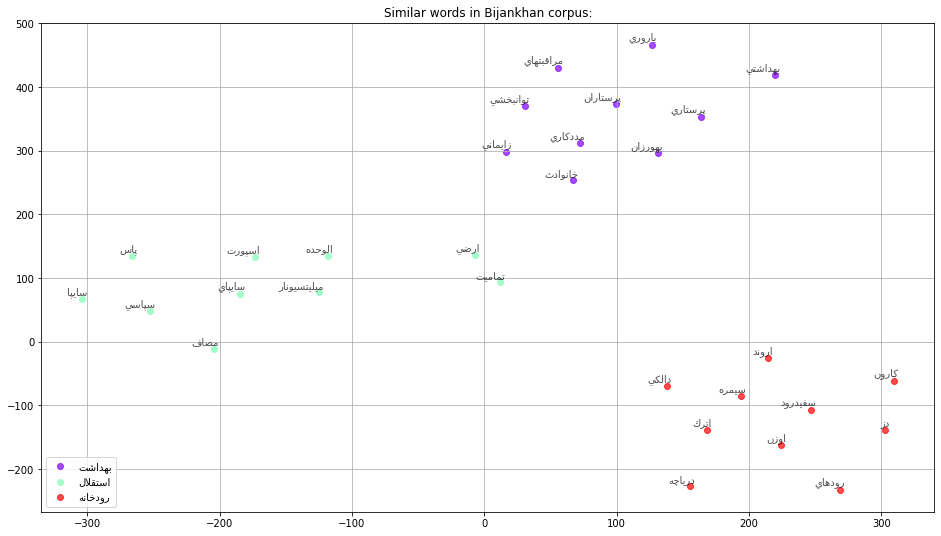

In [ ]:
words = ['بهداشت', 'استقلال', 'رودخانه']
embeddings_en_2d, word_clusters = get_cluster_embeddings(words, w2v_model)
tsne_plot_similar_words('Similar words in Bijankhan corpus:', words, embeddings_en_2d, word_clusters, 0.7, "sim_words.png")